In [1]:
import tensorflow as tf
import tensorflow
import sklearn
import math
import keras
import numpy
import pandas
import os
import time
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.image as mpimg
from keras.utils import np_utils
import matplotlib.pyplot
from keras.models import Sequential,Model
from keras.losses import mse,sparse_categorical_crossentropy
from keras.layers import Dense, Conv2D, Conv1D, Conv3D, Flatten,Activation,MaxPool1D,MaxPooling1D,Dropout,LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from keras.layers import Lambda, Input, Dense
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard

Image dimenssions

In [2]:
img_size1 = 4
img_size2 = 1
num_channels = 1
latent_space_dim =24

In [3]:
#################################### Encoder #######################################
x = tensorflow.keras.layers.Input(shape=(img_size1, img_size2, num_channels), name="encoder_input")
encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer4)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer4)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer4)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample
encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])
encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")
encoder.summary()
#########################################################################################

Model: "encoder_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 4, 1, 1)]    0                                            
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 4, 1, 32)     320         encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_norm_2 (BatchNormalizat (None, 4, 1, 32)     128         encoder_conv_1[0][0]             
__________________________________________________________________________________________________
encoder_activ_layer_2 (LeakyReL (None, 4, 1, 32)     0           encoder_norm_2[0][0]             
______________________________________________________________________________________

In [4]:
#################################### Decoder ####################################
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")
decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=numpy.prod(shape_before_flatten), name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=shape_before_flatten)(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=(2,1), name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=(2,1), name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()


####################################################################################

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 24)]              0         
_________________________________________________________________
decoder_dense_1 (Dense)      (None, 64)                1600      
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 64)          0         
_________________________________________________________________
decoder_conv_tran_1 (Conv2DT (None, 2, 1, 64)          36928     
_________________________________________________________________
decoder_norm_1 (BatchNormali (None, 2, 1, 64)          256       
_________________________________________________________________
decoder_leakyrelu_1 (LeakyRe (None, 2, 1, 64)          0         
_________________________________________________________________
decoder_conv_tran_2 (Conv2DT (None, 4, 1, 64)        

In [5]:
#################################### Variational AutoEncoder ######################
vae_input = tensorflow.keras.layers.Input(shape=(img_size1, img_size2, num_channels), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()
###################################################################################

Model: "VAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 4, 1, 1)]         0         
_________________________________________________________________
encoder_model (Functional)   (None, 24)                96688     
_________________________________________________________________
decoder_model (Functional)   (None, 4, 1, 1)           94849     
Total params: 191,537
Trainable params: 190,769
Non-trainable params: 768
_________________________________________________________________


In [6]:
#################################### Loss fuction Claculating ######################
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance): 
        kl_loss_factor = 1
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss * kl_loss_factor

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)
        loss = reconstruction_loss + kl_loss
        return loss
    return vae_loss
vae.compile(loss=loss_func(encoder_mu, encoder_log_variance), optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001))
encoder.compile(loss=loss_func(encoder_mu, encoder_log_variance), optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001))
decoder.compile(optimizer='adam', loss='mean_squared_error')
# early stopping
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)
########################################################################

In [7]:
##########################################   Image 1 preparation #######################################
datasetf2001 = pd.read_csv('D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/insitu_MH_2001.csv')
data2001=np.array(datasetf2001.iloc[:, 2:6])
datay=np.array(datasetf2001.iloc[:, 6:7])
x_train2001, x_test2001 = train_test_split(data2001, test_size = 0.3, random_state = 0)
y_train, y_test = train_test_split(datay, test_size = 0.3, random_state = 0)
x_train2001 = numpy.reshape(x_train2001, newshape=(x_train2001.shape[0], x_train2001.shape[1],1,1))
x_test2001 = numpy.reshape(x_test2001, newshape=( x_test2001.shape[0], x_test2001.shape[1],1,1))
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
datasetf2001

,x,y,f1,f2,f3,f4,class
0,9.675529,34.272031,0.417279,0.291466,0.178125,0.059537,2
1,9.675799,34.272031,0.416811,0.287341,0.174041,0.062683,2
2,9.676068,34.272031,0.426065,0.295316,0.177864,0.061448,2
3,9.676338,34.272031,0.429296,0.297104,0.183020,0.060946,2
4,9.676607,34.272031,0.419795,0.284674,0.174055,0.057990,2
...,...,...,...,...,...,...,...
520868,9.731854,34.032719,0.310868,0.215319,0.134661,0.085891,0
520869,9.732662,34.032719,0.306000,0.213779,0.131114,0.087122,0
520870,9.732932,34.032719,0.295344,0.203370,0.125614,0.091204,0
520871,9.734010,34.032719,0.289995,0.200042,0.122314,0.085809,0


In [8]:
##########################################   Image 2 preparation #######################################
datasetf2004 = pd.read_csv('D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/insitu_MH_2004.csv')
data2004=np.array(datasetf2004.iloc[:, 2:6])
x_train2004, x_test2004 = train_test_split(data2004, test_size = 0.3, random_state = 0)
x_train2004 = numpy.reshape(x_train2004, newshape=(x_train2004.shape[0], x_train2004.shape[1],1,1))
x_test2004 = numpy.reshape(x_test2004, newshape=( x_test2004.shape[0], x_test2004.shape[1],1,1))
datasetf2004

,x,y,f1,f2,f3,f4,class
0,9.675529,34.272031,0.402543,0.273376,0.161570,0.080215,2
1,9.675799,34.272031,0.390178,0.264081,0.155245,0.083785,2
2,9.676068,34.272031,0.401851,0.276548,0.161460,0.084281,2
3,9.676338,34.272031,0.404697,0.274430,0.161969,0.082022,2
4,9.676607,34.272031,0.389957,0.262261,0.154241,0.082841,2
...,...,...,...,...,...,...,...
520868,9.731854,34.032719,0.297496,0.206746,0.127889,0.103419,0
520869,9.732662,34.032719,0.288847,0.200311,0.122822,0.114320,0
520870,9.732932,34.032719,0.280851,0.193064,0.119144,0.113030,0
520871,9.734010,34.032719,0.269721,0.188169,0.115109,0.110530,0


In [9]:
##########################################   VAE Training #######################################
hist=vae.fit(x_train2001,x_train2001, epochs=1000, batch_size=256 ,validation_data=( x_test2001,x_test2001),callbacks=[es])

Epoch 1/1000
1425/1425 [==============================] - 33s 17ms/step - loss: 0.1517 - val_loss: 0.1489
Epoch 2/1000
1425/1425 [==============================] - 23s 16ms/step - loss: 0.1486 - val_loss: 0.1489
Epoch 3/1000
1425/1425 [==============================] - 24s 16ms/step - loss: 0.1486 - val_loss: 0.1488
Epoch 4/1000
1425/1425 [==============================] - 23s 16ms/step - loss: 0.1486 - val_loss: 0.1488
Epoch 5/1000
1425/1425 [==============================] - 24s 17ms/step - loss: 0.1485 - val_loss: 0.1483
Epoch 6/1000
1425/1425 [==============================] - 25s 18ms/step - loss: 0.1485 - val_loss: 0.1483
Epoch 7/1000
1425/1425 [==============================] - 33s 23ms/step - loss: 0.1485 - val_loss: 0.1482
Epoch 8/1000
1425/1425 [==============================] - 30s 21ms/step - loss: 0.1485 - val_loss: 0.1483
Epoch 9/1000
1425/1425 [==============================] - 32s 22ms/step - loss: 0.1485 - val_loss: 0.1482
Epoch 10/1000
1425/1425 [=====================

In [133]:
##########################################   feature extraction Model preparation #######################################
feature_extraction_model = Model(inputs=encoder.input,
                                 outputs=vae.get_layer('encoder_model').output)
weights = feature_extraction_model.get_weights()
for l in feature_extraction_model.layers:
    l.trainable = False
    print(l.name, l.trainable)
# re-compile the model
feature_extraction_model.compile(loss=loss_func(encoder_mu, encoder_log_variance), optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.01))

encoder_input False
encoder_conv_1 False
encoder_norm_2 False
encoder_activ_layer_2 False
encoder_conv_2 False
encoder_norm_3 False
encoder_activ_layer_3 False
encoder_conv_3 False
encoder_norm_4 False
encoder_activ_layer_4 False
encoder_conv_4 False
encoder_norm_5 False
encoder_activ_layer_5 False
flatten False
encoder_mu False
encoder_log_variance False
encoder_output False


In [134]:
##########################################   siamese VAE creation #######################################
vae_in_1 = tensorflow.keras.layers.Input(shape=(img_size1, img_size2, num_channels), name="s_input1")
vae_in_2 = tensorflow.keras.layers.Input(shape=(img_size1, img_size2, num_channels), name="s_input2")
concatted = tf.keras.layers.Concatenate()([feature_extraction_model(vae_in_1), feature_extraction_model(vae_in_2)])
prediction = Dense(3, activation='softmax',name="classifier")(concatted)
Siamese_vae=Model(inputs=[vae_in_1,vae_in_2],outputs=prediction)
Siamese_vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
Siamese_vae.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
s_input1 (InputLayer)           [(None, 4, 1, 1)]    0                                            
__________________________________________________________________________________________________
s_input2 (InputLayer)           [(None, 4, 1, 1)]    0                                            
__________________________________________________________________________________________________
model_28 (Functional)           (None, 24)           96688       s_input1[0][0]                   
                                                                 s_input2[0][0]                   
__________________________________________________________________________________________________
concatenate_22 (Concatenate)    (None, 48)           0           model_28[0][0]            

In [135]:
##########################################   Siamese VAE Training #######################################
import time
start_time = time.time()
ces = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=10)
history=Siamese_vae.fit([x_train2001,x_train2004],y_train,batch_size=256,epochs=1000,callbacks=[ces]) 
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/1000
1425/1425 [==============================] - 6s 3ms/step - loss: 0.1839 - accuracy: 0.9360
Epoch 2/1000
1425/1425 [==============================] - 4s 3ms/step - loss: 0.1174 - accuracy: 0.9533
Epoch 3/1000
1425/1425 [==============================] - 4s 3ms/step - loss: 0.1070 - accuracy: 0.9571
Epoch 4/1000
1425/1425 [==============================] - 4s 3ms/step - loss: 0.1008 - accuracy: 0.9598: 0s - loss: 0.1007 - accuracy: 0.95
Epoch 5/1000
1425/1425 [==============================] - 4s 3ms/step - loss: 0.0961 - accuracy: 0.9612
Epoch 6/1000
1425/1425 [==============================] - 4s 3ms/step - loss: 0.0939 - accuracy: 0.9623
Epoch 7/1000
1425/1425 [==============================] - 5s 3ms/step - loss: 0.0897 - accuracy: 0.9638
Epoch 8/1000
1425/1425 [==============================] - 6s 4ms/step - loss: 0.0895 - accuracy: 0.9640
Epoch 9/1000
1425/1425 [==============================] - 4s 3ms/step - loss: 0.0863 - accuracy: 0.9651
Epoch 10/1000
1425/1425 [===

Epoch 78/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0728 - accuracy: 0.9720
Epoch 79/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0758 - accuracy: 0.9712
Epoch 80/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0747 - accuracy: 0.9718
Epoch 81/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0735 - accuracy: 0.9719
Epoch 82/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0750 - accuracy: 0.9719
Epoch 83/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0749 - accuracy: 0.9714
Epoch 84/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0740 - accuracy: 0.9718
Epoch 85/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0760 - accuracy: 0.9711
Epoch 86/1000
1425/1425 [==============================] - 3s 2ms/step - loss: 0.0757 - accuracy: 0.9717
Epoch 87/1000
1425/1425 [==============================

dict_keys(['loss', 'accuracy'])


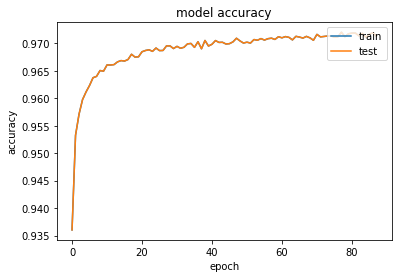

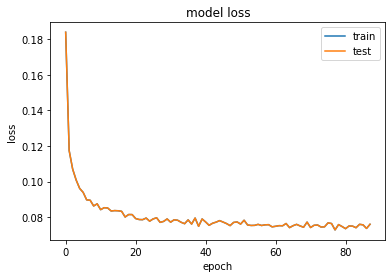

In [136]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [137]:
data2001 = numpy.reshape(data2001, newshape=(data2001.shape[0], data2001.shape[1],1,1))
data2004 = numpy.reshape(data2004, newshape=(data2004.shape[0], data2004.shape[1],1,1))
Y_pred=Siamese_vae.predict([data2001,data2004])
datasetvae2001_class = pd.DataFrame(datasetf2001['x'])
datasetvae2004_class = pd.DataFrame(datasetf2001['x'])
datasetvae2001_class['y'] = pd.DataFrame(datasetf2001['y'],columns=['y'])
datasetvae2004_class['y'] = pd.DataFrame(datasetf2001['y'],columns=['y'])
datasetvae2001_class['f1'] = pd.DataFrame(datasetf2001['f1'])
datasetvae2001_class['f2'] = pd.DataFrame(datasetf2001['f2'])
datasetvae2001_class['f3'] = pd.DataFrame(datasetf2001['f3'])
datasetvae2001_class['f4'] = pd.DataFrame(datasetf2001['f4'])
datasetvae2004_class['f1'] = pd.DataFrame(datasetf2004['f1'])
datasetvae2004_class['f2'] = pd.DataFrame(datasetf2004['f2'])
datasetvae2004_class['f3'] = pd.DataFrame(datasetf2004['f3'])
datasetvae2004_class['f4'] = pd.DataFrame(datasetf2004['f4'])
datasetvae2001_class['class'] = datay
datasetvae2001_class['pred'] = np.argmax(Y_pred, axis=1)
datasetvae2001_class.to_csv(r'D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/y_pred_insitu_MH_2001.csv')
datasetvae2004_class['class'] = datay
datasetvae2004_class['pred'] = np.argmax(Y_pred, axis=1)
datasetvae2004_class.to_csv(r'D:/etm data/GoogleEarthEngine/Landsat_07/dataset_2001_2004/y_pred_insitu_MH_2004.csv')

In [138]:
##########################################   Metrix preparation #######################################
from sklearn.metrics import recall_score
mse = sklearn.metrics.mean_squared_error(datay, np.argmax(Y_pred, axis=1))
rmse = math.sqrt(mse)
r2=sklearn.metrics.r2_score(datay, np.argmax(Y_pred, axis=1))
precision_sc=sklearn.metrics.precision_score(datay, np.argmax(Y_pred, axis=1), average='macro')
f1_sc=sklearn.metrics.f1_score(datay, np.argmax(Y_pred, axis=1), average='macro')
confusion_mat=sklearn.metrics.confusion_matrix(datay, np.argmax(Y_pred, axis=1))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(datay, np.argmax(Y_pred, axis=1), pos_label=2)
recall_score=recall_score(datay, np.argmax(Y_pred, axis=1), average=None)
auc=sklearn.metrics.auc(fpr, tpr)

In [139]:
recall_score

array([0.98326306, 0.96927489, 0.96863443])

In [140]:
rmse

0.2858444632847108

In [141]:
r2

0.9053850980441429

In [142]:
precision_sc

0.9742245388203278

In [143]:
f1_sc

0.9739440429446663

In [144]:
fpr

array([0.        , 0.0200584 , 0.25859726, 1.        ])

In [145]:
tpr

array([0.        , 0.96863443, 0.97489104, 1.        ])

In [146]:
auc

0.9736126160516413

In [147]:
from sklearn.metrics import accuracy_score
accuracy=sklearn.metrics.accuracy_score(datay, np.argmax(Y_pred, axis=1))
accuracy*100

97.43565130079693

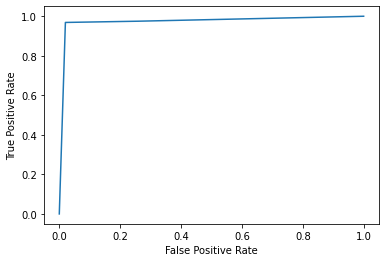

In [148]:
from sklearn.metrics import RocCurveDisplay
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

<AxesSubplot:>

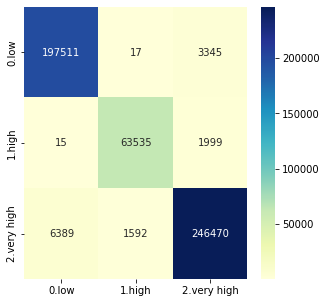

In [149]:
import seaborn as sn
df_cm = pd.DataFrame(confusion_mat, index = ["0.low","1.high","2.very high"],columns = ["0.low","1.high","2.very high"])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")